# **Data Visualisation**

## Objectives

* Visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* input/datasets/cherry_leaf_dataset/cherry-leaves/test
* input/datasets/cherry_leaf_dataset/cherry-leaves/train
* input/datasets/cherry_leaf_dataset/cherry-leaves/validation

## Outputs

* Count of images per class in train/validation/test
* Distribution plot of image widths and heights
* Per‑class mean & variability visualisations
* Difference map highlighting powdery mildew features
* Sample montages of healthy vs. mildew leaves

---

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread
import random

## Change working directory

* We update the working directory as in Notebook 01.

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-MildewDetection'

## Set Train, Validation and Test Paths

In [5]:
my_data_dir = 'input/datasets/cherry_leaf_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [6]:
from pathlib import Path

# versioning & output directory
version = "v1"
base_out = Path("outputs") / version
figures_out = base_out / "figures"

# create folders if they don’t exist
figures_out.mkdir(parents=True, exist_ok=True)

print(f"Saving all figures into: {figures_out}")


Saving all figures into: outputs/v1/figures


## Set Label Names

In [7]:
labels = sorted(
    [p.name for p in Path(train_path).iterdir() if p.is_dir()]
)
print("Labels:", labels)

Labels: ['healthy', 'powdery_mildew']


---

# Visualisation of Image Data

---

## Class-count Summary - Ensuring Balance

* The below plots the number of images per class in each split (test, train, validate).
* If the bars are roughly the same height we can be confident our data is balanced.
* If there are significant discrepancies we may need to apply balancing techniques such as oversampling or undersampling.

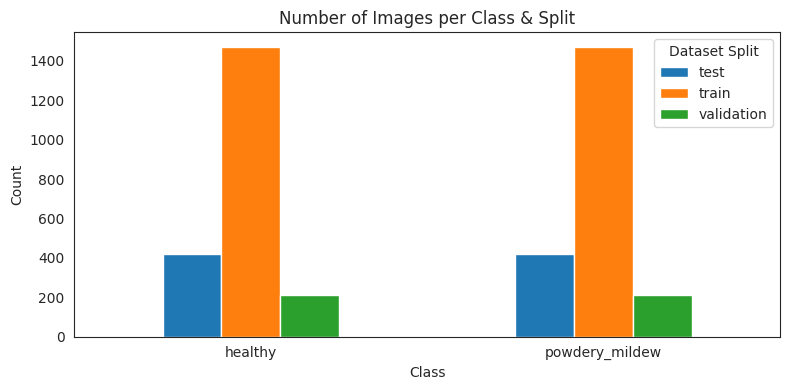

In [8]:
# Wrap inputs in Path to iterate over
train_dir = Path(train_path)
val_dir = Path(val_path)
test_dir = Path(test_path)

# Count images per class for each split
splits = {
    'train': train_dir,
    'validation': val_dir,
    'test': test_dir
}

# build counts
counts = []
for split_name, split_dir in splits.items():
    for cls in labels:
        n = len(list((split_dir/cls).glob('*')))  # count all files
        counts.append({'split': split_name, 'class': cls, 'count': n})

df_counts = pd.DataFrame(counts)

# pivot for plotting
df_pivot = df_counts.pivot(index='class', columns='split', values='count')

# plot
ax = df_pivot.plot(kind='bar', figsize=(8,4))
ax.set_title('Number of Images per Class & Split')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Dataset Split')
plt.tight_layout()

# save
plt.savefig(figures_out/'class_counts.png')
plt.show()

#### Conclusion

The bar chart confirms that both “healthy” and “powdery_mildew” classes are closely balanced across the train, validation, and test splits.

With class counts verified, we can proceed knowing our dataset isn’t biased by uneven class representation.

---

## Image Shape Distribution

In the CRISP‑DM Data Understanding phase, we must characterise the raw inputs before we build a model.

Plotting the distribution of image widths and heights lets us:

- Detect outliers that should be removed or re‑collected.
- Choose a target input size for our neural network that minimises distortion.
- Ensure preprocessing consistency so we don’t inadvertently warp some leaves more than others, which could bias the model.

This plot allows us to demonstrate that all images conform to expected dimensions and to define a resize step in the pipeline if required.

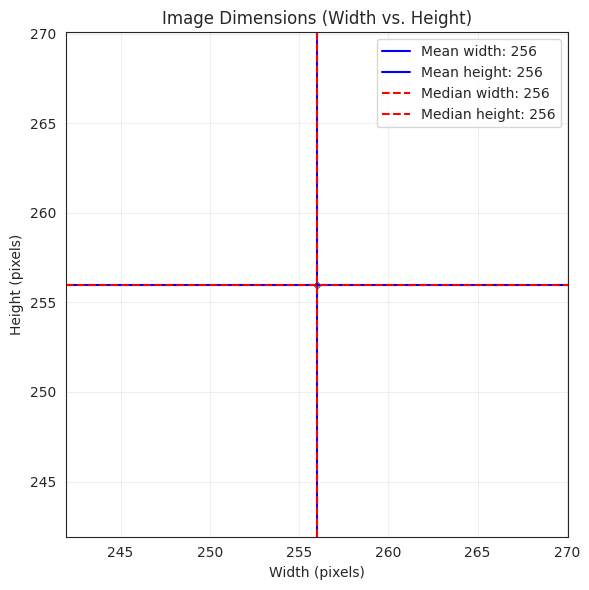

Selected image_shape = (256, 256, 3)


In [9]:
# All (height, width) gathered from the train split
dim_h, dim_w = [], []
for cls in labels:
    for img_file in (train_dir/cls).glob('*'):
        img = imread(str(img_file))
        h, w, _ = img.shape
        dim_h.append(h)
        dim_w.append(w)

# Compute mean and median
avg_h, avg_w = int(np.mean(dim_h)), int(np.mean(dim_w))
med_h, med_w = int(np.median(dim_h)), int(np.median(dim_w))

# Scatter‑plot width vs height
plt.figure(figsize=(6,6))
plt.scatter(dim_w, dim_h, s=10, alpha=0.2, color='gray')
# mean lines
plt.axvline(avg_w, color='blue', linestyle='-', label=f'Mean width: {avg_w}')
plt.axhline(avg_h, color='blue', linestyle='-', label=f'Mean height: {avg_h}')
# median lines
plt.axvline(med_w, color='red', linestyle='--', label=f'Median width: {med_w}')
plt.axhline(med_h, color='red', linestyle='--', label=f'Median height: {med_h}')

plt.title('Image Dimensions (Width vs. Height)')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()

# Save & show
plt.savefig(figures_out/'image_shape_scatter.png')
plt.show()

# Select final image_shape for the model
image_shape = (avg_h, avg_w, 3)
print('Selected image_shape =', image_shape)

#### Conclusion

Our analysis confirms that every image in the training set is already 256 × 256 px, with no outliers. This uniformity means no additional cropping or padding is required.

---

## Per-class Mean and Variability

In this step we compute, for each class, the mean image (the “typical” leaf) and the pixel-wise standard deviation (the variability) across the training set.  
- The mean highlights the average colour/texture patterns for healthy vs. mildew leaves.  
- The standard-deviation map shows which regions vary most (e.g. lesion spots), guiding us toward features that discriminate the two classes.

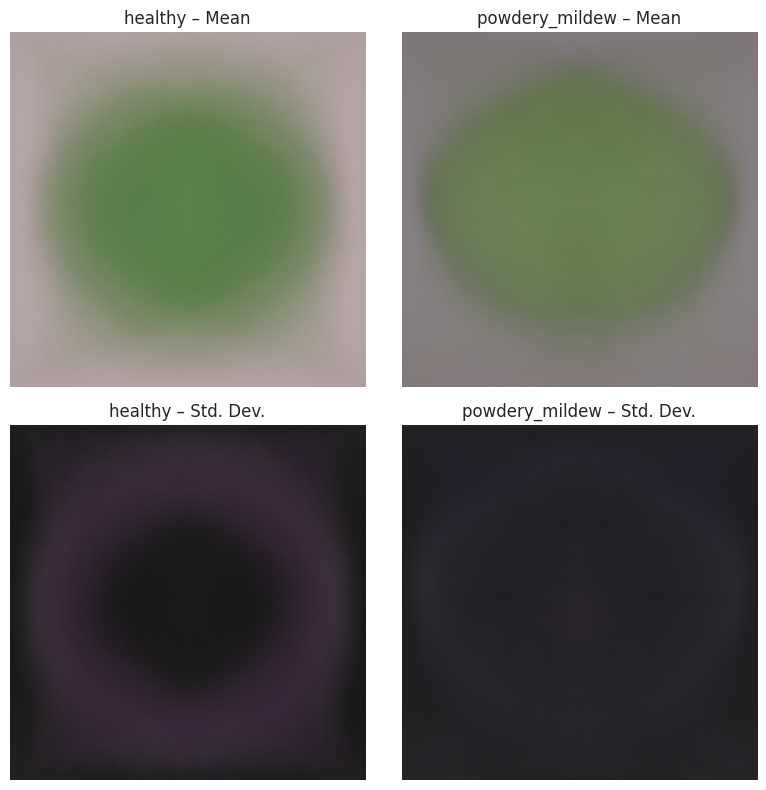

In [10]:
# Helper to load and stack images for a given class
def compute_stats_for_class(class_dir):
    imgs = []
    for img_path in (class_dir).glob('*'):
        img = imread(str(img_path)).astype(np.float32) / 255.0
        imgs.append(img)
    stack = np.stack(imgs, axis=0)  # shape = (Num, Hgt, Wdth, Chnl)
    mean_img = np.mean(stack, axis=0)
    std_img  = np.std(stack, axis=0)
    return mean_img, std_img

# Compute mean and std for each label
stats = {}
for cls in labels:
    class_dir = train_dir / cls
    mean_img, std_img = compute_stats_for_class(class_dir)
    stats[cls] = (mean_img, std_img)

# Plot grid: row 1 = means, row 2 = stds
n = len(labels)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
for i, cls in enumerate(labels):
    mean_img, std_img = stats[cls]
    # Mean
    ax = axes[0, i]
    ax.imshow(mean_img)
    ax.axis('off')
    ax.set_title(f"{cls} – Mean")
    # Variability
    ax = axes[1, i]
    ax.imshow(std_img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{cls} – Std. Dev.")

plt.tight_layout()
plt.savefig(figures_out/'mean_std_per_class.png')
plt.show()

#### Conclusion

The per-class mean images reveal the overall colour and texture differences between healthy and powdery-mildew leaves, while the standard-deviation maps highlight the most variable regions (e.g. fungal spots). These visual summaries confirm that pixel-level patterns exist which our model can leverage, and they’ll inform any augmentation or feature-engineering choices downstream.

---

## Difference Map

Here we visualise the pixel-wise difference between the average mildew leaf and the average healthy leaf:

- Positive values (red) indicate regions where mildew leaves are brighter.  
- Negative values (blue) indicate regions where healthy leaves are brighter.  
- This highlights exactly which areas and colour channels carry the strongest mildew signal.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


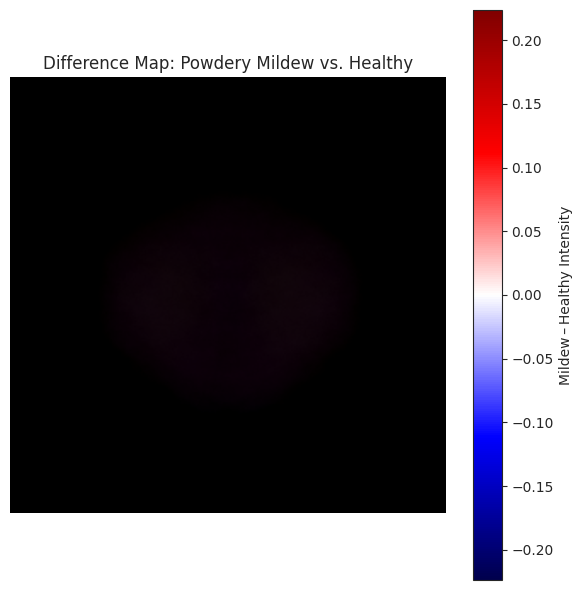

In [11]:
# Extract per-class mean images
mean_healthy, _ = stats['healthy']
mean_mildew, _ = stats['powdery_mildew']

# Compute difference
diff_img = mean_mildew - mean_healthy

# Plot with a diverging colour-map centered at zero
plt.figure(figsize=(6,6))
plt.imshow(diff_img, cmap='seismic', vmin=-np.max(np.abs(diff_img)), vmax=np.max(np.abs(diff_img)))
plt.colorbar(label='Mildew – Healthy Intensity')
plt.title('Difference Map: Powdery Mildew vs. Healthy')
plt.axis('off')
plt.tight_layout()

# Save & display
plt.savefig(figures_out/'difference_map.png')
plt.show()

#### Conclusion

The difference map reveals a subtle ring around the leaf edge and faint blotches where powdery mildew slightly alters pixel intensity compared to healthy leaves. Although the changes are minor, they identify regions of interest that can inform our feature‐extraction and augmentation in the modelling phase.

---

## Sample Montages

To get a qualitative sense of each class we’ll display a small grid of randomly selected leaves from the training set for each class.

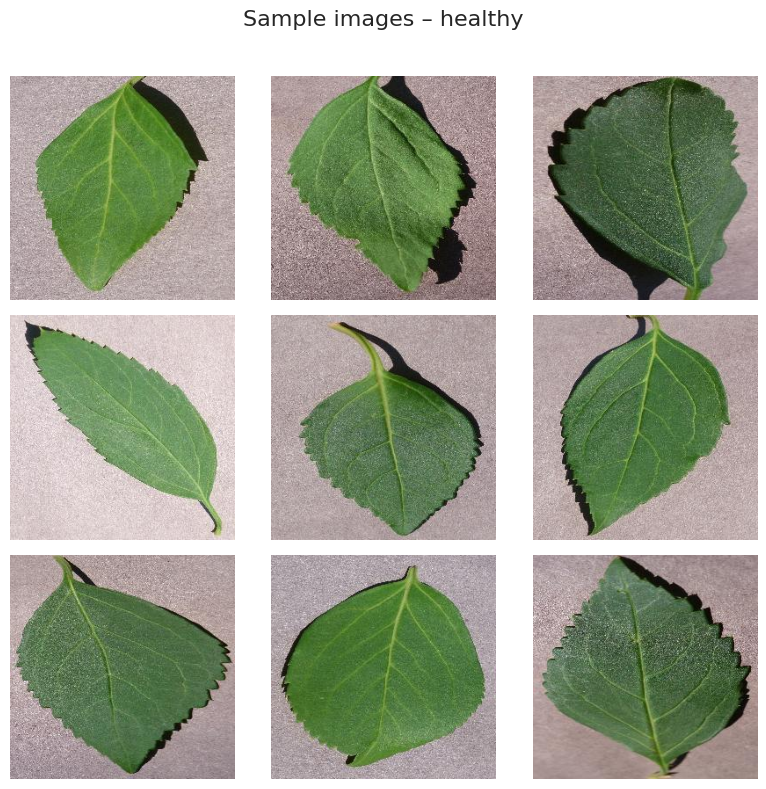

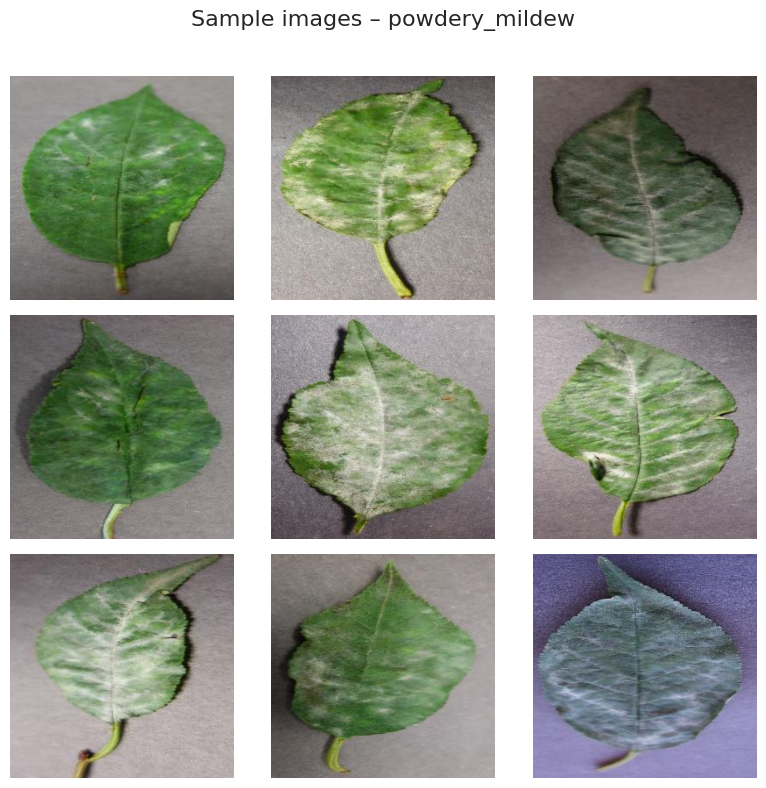

In [13]:
# Number of samples per class
n_samples = 9
grid_size = int(n_samples**0.5)  # e.g. 3×3 grid

for cls in labels:
    # Collect all image paths for this class
    cls_paths = list((train_dir/cls).glob('*'))
    # Randomly pick n_samples
    samples = random.sample(cls_paths, n_samples)
    
    # Plot grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8,8))
    fig.suptitle(f"Sample images – {cls}", fontsize=16)
    
    for ax, img_path in zip(axes.flatten(), samples):
        img = imread(str(img_path))
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Save each class montage
    plt.savefig(figures_out/f"montage_{cls}.png")
    plt.show()

#### Conclusion

These montages provide a quick visual check: all healthy leaves appear uniformly green with clear vein structure, while powdery-mildew samples show the whitish speckling. We can proceed with confidence that our labels and image quality are sound for the modelling phase.

---

## Overall Conclusion

In this notebook we completed the CRISP-DM Data Understanding phase by:

- Verifying class balance across train/validation/test
- Confirming uniform image dimensions (256 × 256 px)
- Visualising per-class mean and variability to uncover discriminative pixel patterns
- Highlighting mildew vs. healthy differences via a diverging heat map
- Spot-checking raw samples with montages to validate label quality

Together, these steps give us confidence in our data’s consistency and the presence of mildew signals.

---

## Next Steps

We’re now ready to move into **Notebook 3: Data Preparation & Modelling**, where we will:

1. Define and apply any necessary preprocessing (resizing, normalization, augmentations)
2. Build and train our classification pipeline
3. Evaluate model performance with learning curves, confusion matrices, and test‐set metrics

All figures have been saved automatically to `outputs/v1/figures/`.